<a href="https://www.kaggle.com/code/negmgh/cardiac-echocardiogram-model-evaluation-testingm?scriptVersionId=219824738" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="background-color: #113966; font-family: 'Arial', sans-serif; font-size: 32px; text-align: center; color: #fc7f03; padding: 15px; border-radius: 25px; text-shadow: 2px 2px 6px rgba(0, 0, 0, 0.5); border: 3px solid #fc7f03;">Cardiac Echocardiogram Model Evaluation and Testing</p>

![](https://cdn.prod.website-files.com/5ff99f5f7aec6fe4770f6b92/616f144e8b372e2724a33eb0_Apical%204-Chamber%20View%20(A4C).png)

# Reading Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/echo2022/sample_submission.csv
/kaggle/input/echo2022/train_data.csv
/kaggle/input/echo2022/test_data/test_data/4CH/patient0004_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0044_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0017_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0002_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0024_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0035_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0037_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0034_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0033_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0043_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0030_4CH_sequence.npy
/kaggle/input/echo2022/test_data/test_data/4CH/patient0031_4CH_sequence.npy
/kagg

Example of a .npy file with shape (num_images, height, width, channels)

Use Case in Echocardiography
Each 4-channel image could represent:

1. B-mode grayscale image
2. Color Doppler data
3. Tissue Doppler Imaging (TDI)
4. Strain or velocity map

This format is useful for deep learning applications, where neural networks (like CNNs) can process multiple channels simultaneously.

In [2]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm    #  tqdm library provides a progress bar for loops in Python. It is especially useful when working with large datasets, training deep learning models, or processing large .npy files.
import tensorflow as tf

In [3]:
# Load the dataset
loaded_data_example = np.load("/kaggle/input/echo2022/train_data/train_data/2CH/patient076_2CH_sequence.npy")

# Print dataset shape
print("Loaded data shape:", loaded_data_example.shape)
loaded_data_example

Loaded data shape: (18, 973, 591)


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [4]:
train_data = pd.read_csv("../input/echo2022/train_data.csv")
train_data

,Patient_number,LV_ef
0,patient001,58.9
1,patient002,37.3
2,patient003,65.3
3,patient004,38.4
4,patient005,58.5
...,...,...
395,patient396,30.9
396,patient397,33.8
397,patient398,61.0
398,patient399,57.8


In [5]:
sample_sub = pd.read_csv("../input/echo2022/sample_submission.csv")

In [6]:
train_2CH_dir = "../input/echo2022/train_data/train_data/2CH/"
train_4CH_dir = "../input/echo2022/train_data/train_data/4CH/"
test_2CH_dir = "../input/echo2022/test_data/test_data/2CH/"
test_4CH_dir = "../input/echo2022/test_data/test_data/4CH/"

In [7]:
# Import metadata about the echo images
sequence_number = []
train_img_w = []
train_img_h = []
for i in tqdm(os.listdir(train_2CH_dir)):
    if i.endswith(".npy"):
        number, width, height = np.load(train_2CH_dir + i).shape
        sequence_number.append(number)
        train_img_w.append(width)
        train_img_h.append(height)

100%|██████████| 401/401 [01:41<00:00,  3.93it/s]


In [8]:
# Because of large filesize we may need to import the image data into Python in batches. 
# This can be done using batch generators.

def batch_generator(batch_size, gen_x): 
    batch_features = np.zeros((batch_size,10, 256, 256))
    batch_labels = np.zeros((batch_size,1)) 
    while True:
        for i in range(batch_size):
            batch_features[i] , batch_labels[i] = next(gen_x)
        yield np.expand_dims(batch_features,4), batch_labels

def generate_data(filelist, img_path, gt_df):
    while True:
        for i in filelist:
            if i.endswith(".npy"):
                img = np.load(img_path + i)
                img = img[:10]
                resized_img = np.zeros((10,256,256))
                for j,k in enumerate(img):
                    resized_img[j,:,:] = cv2.resize(k, (256,256), interpolation= cv2.INTER_LINEAR )
                y = float(gt_df.LV_ef[np.where(gt_df.Patient_number == i.split("_")[0])[0]])

                yield resized_img, y

In [9]:
test = batch_generator(5,generate_data(os.listdir(train_4CH_dir),train_4CH_dir,train_data))

print("The shape of one batch of images (batch size = 5):")
print(next(test)[0].shape)

The shape of one batch of images (batch size = 5):


<ipython-input-8-ec82b48a202a>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(gt_df.LV_ef[np.where(gt_df.Patient_number == i.split("_")[0])[0]])
<ipython-input-8-ec82b48a202a>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(gt_df.LV_ef[np.where(gt_df.Patient_number == i.split("_")[0])[0]])
<ipython-input-8-ec82b48a202a>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(gt_df.LV_ef[np.where(gt_df.Patient_number == i.split("_")[0])[0]])


(5, 10, 256, 256, 1)


<ipython-input-8-ec82b48a202a>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(gt_df.LV_ef[np.where(gt_df.Patient_number == i.split("_")[0])[0]])
<ipython-input-8-ec82b48a202a>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(gt_df.LV_ef[np.where(gt_df.Patient_number == i.split("_")[0])[0]])


# Model Training

**The model is a ConvLSTM architecture where CNN extracts spatial features, and LSTM captures temporal dependencies.**

In [10]:
import tensorflow as tf

model = tf.keras.models.Sequential()

# CNN feature extraction
model.add(
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'), 
        input_shape=(10, 256, 256, 1)
    )
)
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2))))

model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2))))

model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization()))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2))))

# Flatten before LSTM
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D()))

# LSTM for temporal dependencies
model.add(tf.keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))

# Fully connected output
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

# Compile with AdamW optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 256, 256, 32)    │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 256, 256, 32)    │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 128, 128, 32)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 128, 128, 64)    │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 10, 128, 128, 64)    │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 64, 64, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 10, 64, 64, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 10, 64, 64, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 10, 32, 32, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145,089 (566.75 KB)

 Trainable params: 144,641 (565.00 KB)

 Non-trainable params: 448 (1.75 KB)

✅ Batch Normalization for faster convergence.

✅ MaxPooling2D instead of GlobalPooling to retain spatial features.

✅ More CNN filters to extract richer features.

✅ Dropout & Recurrent Dropout to prevent overfitting.

✅ AdamW optimizer for better generalization.

# Model Fitting

<ipython-input-8-ec82b48a202a>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(gt_df.LV_ef[np.where(gt_df.Patient_number == i.split("_")[0])[0]])
<ipython-input-8-ec82b48a202a>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(gt_df.LV_ef[np.where(gt_df.Patient_number == i.split("_")[0])[0]])
<ipython-input-8-ec82b48a202a>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(gt_df.LV_ef[np.where(gt_df.Patient_number == i.split("_")[0])[0]])
<ipython-input-8-ec82b48a202a>:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(gt_df.LV_ef[np.where(gt_df.Patient_numb

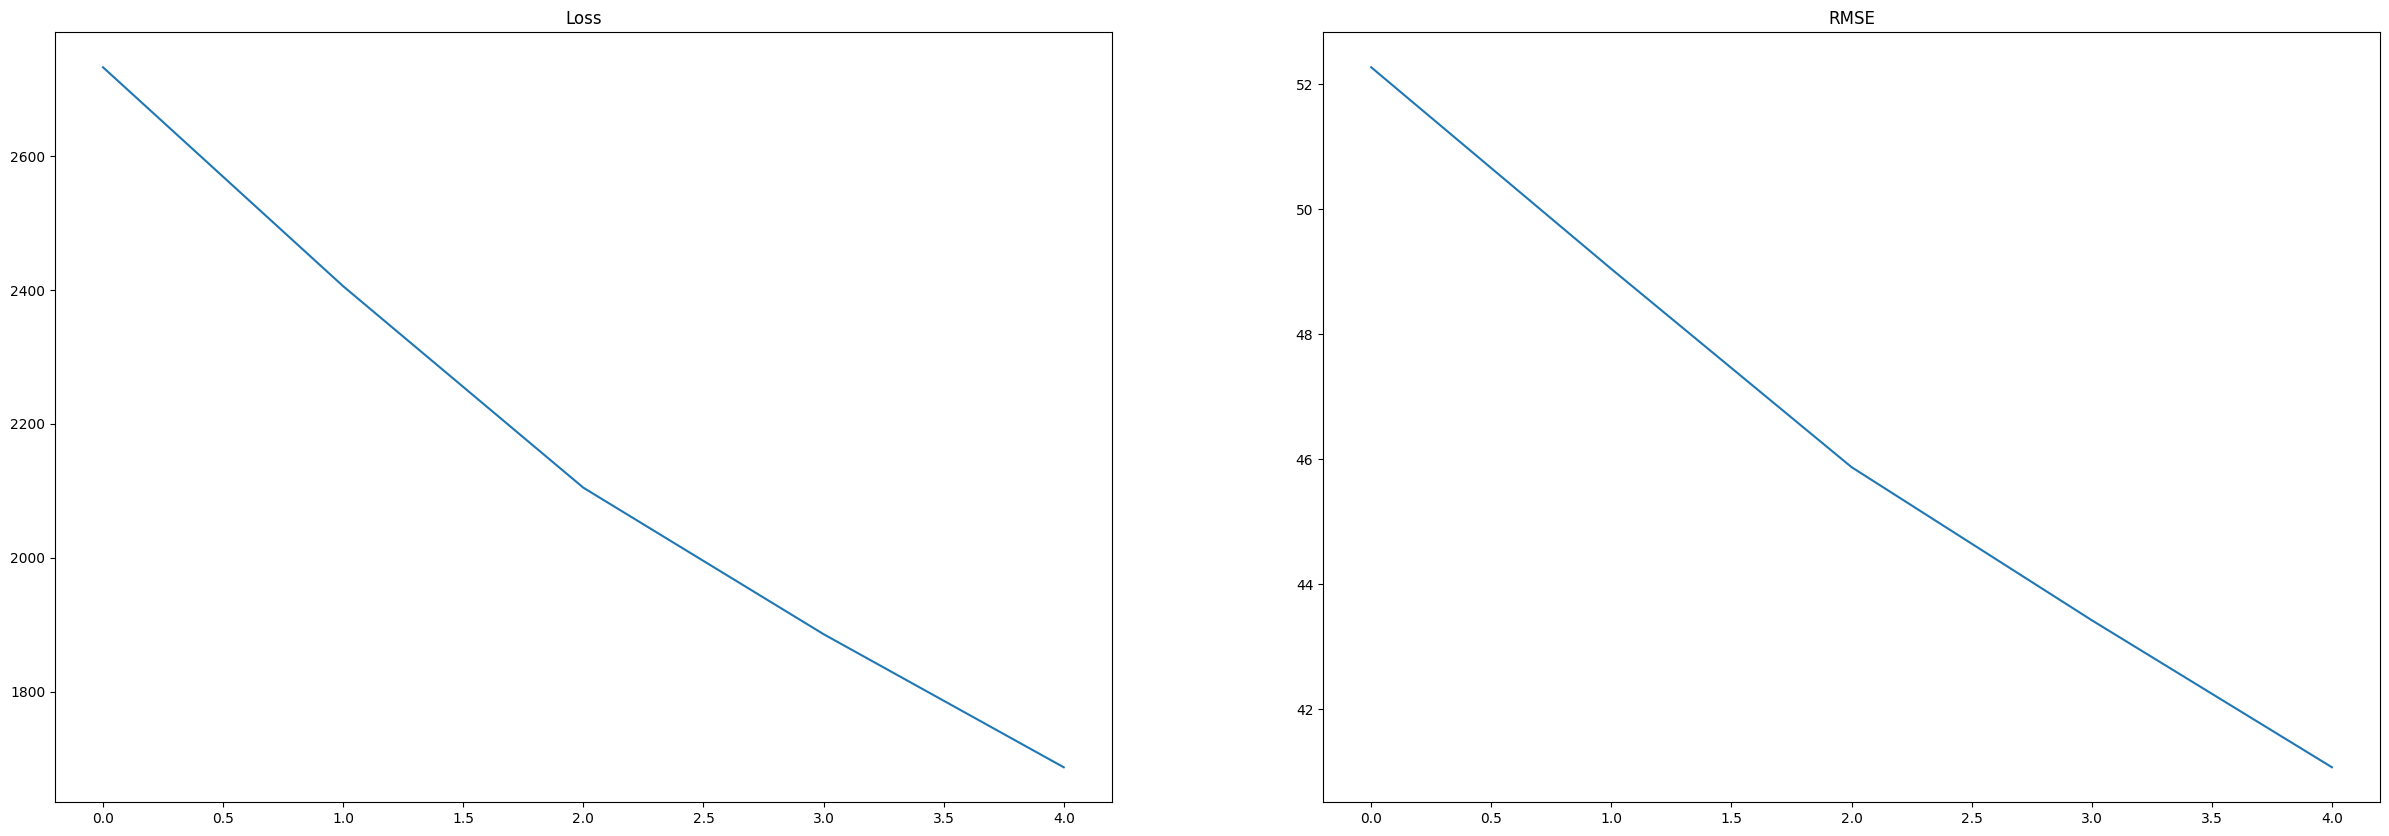

In [11]:
batch_size = 5
num_epoch = 5
steps = len(os.listdir(train_4CH_dir))//batch_size
history = model.fit(x=batch_generator(batch_size,generate_data(os.listdir(train_4CH_dir),train_4CH_dir,train_data)), epochs=num_epoch, 
                            steps_per_epoch=steps, verbose=0)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(30)
ax1.plot(history.history["loss"])
ax1.set_title("Loss")
ax2.plot(history.history["root_mean_squared_error"])
ax2.set_title("RMSE")
plt.show()

# Model Prediction

In [12]:
y_pred=[]
for i in tqdm(sorted(os.listdir(test_4CH_dir))):
    if i.endswith(".npy"):
        img = np.load(test_4CH_dir + i)
        img = img[:10]
        resized_img = np.zeros((10,256,256))
        for j,k in enumerate(img):
            resized_img[j,:,:] = cv2.resize(k, (256,256), interpolation= cv2.INTER_LINEAR )
        y_pred.append(model.predict(np.expand_dims(np.expand_dims(resized_img,3),0)))

  0%|          | 0/51 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  4%|▍         | 2/51 [00:02<00:56,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  6%|▌         | 3/51 [00:02<00:43,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  8%|▊         | 4/51 [00:03<00:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 10%|▉         | 5/51 [00:04<00:34,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 12%|█▏        | 6/51 [00:04<00:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 14%|█▎        | 7/51 [00:05<00:29,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 16%|█▌        | 8/51 [00:05<00:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 18%|█▊        | 9/51 [00:06<00:30,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 20%|█▉        | 10/51 [00:07<00:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 22%|██▏       | 11/51 [00:08<00:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 24%|██▎       | 12/51 [00:08<00:23,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 25%|██▌       | 13/51 [00:09<00:21,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 27%|██▋       | 14/51 [00:09<00:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 29%|██▉       | 15/51 [00:10<00:22,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 31%|███▏      | 16/51 [00:10<00:21,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 33%|███▎      | 17/51 [00:11<00:22,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 35%|███▌      | 18/51 [00:12<00:20,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 37%|███▋      | 19/51 [00:12<00:19,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 39%|███▉      | 20/51 [00:13<00:20,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 41%|████      | 21/51 [00:14<00:18,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 43%|████▎     | 22/51 [00:14<00:15,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 45%|████▌     | 23/51 [00:15<00:15,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 47%|████▋     | 24/51 [00:15<00:16,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 49%|████▉     | 25/51 [00:16<00:15,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 51%|█████     | 26/51 [00:17<00:15,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 53%|█████▎    | 27/51 [00:17<00:15,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 55%|█████▍    | 28/51 [00:18<00:14,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 57%|█████▋    | 29/51 [00:18<00:13,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 59%|█████▉    | 30/51 [00:19<00:14,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 61%|██████    | 31/51 [00:20<00:14,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 63%|██████▎   | 32/51 [00:21<00:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 65%|██████▍   | 33/51 [00:21<00:12,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 67%|██████▋   | 34/51 [00:22<00:11,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 69%|██████▊   | 35/51 [00:23<00:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 71%|███████   | 36/51 [00:23<00:09,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 73%|███████▎  | 37/51 [00:24<00:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 75%|███████▍  | 38/51 [00:25<00:08,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 76%|███████▋  | 39/51 [00:26<00:08,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 78%|███████▊  | 40/51 [00:26<00:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 80%|████████  | 41/51 [00:27<00:06,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 82%|████████▏ | 42/51 [00:27<00:05,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 84%|████████▍ | 43/51 [00:28<00:04,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 86%|████████▋ | 44/51 [00:28<00:03,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 88%|████████▊ | 45/51 [00:29<00:03,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 90%|█████████ | 46/51 [00:30<00:03,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 92%|█████████▏| 47/51 [00:30<00:02,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 94%|█████████▍| 48/51 [00:31<00:01,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 96%|█████████▌| 49/51 [00:31<00:01,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 98%|█████████▊| 50/51 [00:32<00:00,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


100%|██████████| 51/51 [00:32<00:00,  1.56it/s]


In [13]:
sample_sub.LV_ef = np.asarray(y_pred).ravel()
sample_sub

,Patient_number,LV_ef
0,patient0001,14.137287
1,patient0002,14.060330
2,patient0003,14.139774
3,patient0004,14.144932
4,patient0005,14.081738
5,patient0006,14.132618
6,patient0007,14.077913
7,patient0008,14.034078
8,patient0009,14.063881
9,patient0010,14.087292


In [14]:
sample_sub.to_csv("submission.csv",index=False)